# Estradiol: Noise Tolerance

Here, the estradiol dataset presented in Figure 3 of the main paper is corrupted with a series of instances of Gaussian noise, with different target varainces. Each corrupted dataset was then be processed using NMR-EsPy as per the original dataset. The results are then compared with the corresponding PSYCHE dataset, corrupted with comparable noise instances.

## Defining Paths

In [16]:
from pathlib import Path
import nmrespy as ne

root = Path("../../..")
data_dir = root / "data" / "estradiol" / "1"
output_dir = root / "code" / "reviewer-1" / "estradiol-noise-tolerance" / "output"
output_dir.mkdir(exist_ok=True, parents=True)

## Loading the Original 2DJ Data

In [17]:
estimator_dir = output_dir / "estimators"
estimator_dir.mkdir(exist_ok=True, parents=True)
estimator_base_path = estimator_dir / "estimator_base.pkl"

if estimator_base_path.is_file():
    estimator_base = ne.Estimator2DJ.from_pickle(estimator_base_path)
else:
    estimator_base = ne.Estimator2DJ.new_bruker(data_dir)
    estimator_base.phase_data(p0=4.563, p1=-6.239)
    estimator_base.to_pickle(estimator_base_path)

Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_base.pkl.


## Creating Noisy 2DJ Datasets 

In [18]:
from copy import deepcopy
import numpy as np

awgn_generator = np.random.default_rng(0)

def add_noise(data: np.ndarray, stdev: float) -> None:
    real = awgn_generator.normal(loc=0.0, scale=stdev, size=data.shape)
    imag = awgn_generator.normal(loc=0.0, scale=stdev, size=data.shape)
    data += real + 1j * imag

stdevs = [0, 5, 10, 15, 20, 25, 30]
estimator_path_tmpl = str(estimator_dir / "estimator_{}.pkl")

def get_estimator_path(stdev):
    if stdev == 0:
        return Path(estimator_path_tmpl.format("base"))
    return Path(estimator_path_tmpl.format(stdev))
    
all_paths = [get_estimator_path(stdev) for stdev in stdevs]
estimators = {}

if all([path.is_file() for path in all_paths]):
    for stdev, path in zip(stdevs, all_paths):
        estimator = ne.Estimator2DJ.from_pickle(path)
        estimators[stdev] = estimator
else: 
    for stdev in stdevs:
        estimator_noisy = deepcopy(estimator_base)
        path = Path(estimator_path_tmpl.format(stdev))
        if stdev != 0:
            add_noise(estimator_noisy._data, stdev)
        estimators[stdev] = estimator_noisy
        estimator_noisy.to_pickle(get_estimator_path(stdev), force_overwrite=True)

Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_base.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_5.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_10.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_15.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_20.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_25.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/estimators/estimator_30.pkl.


## Visualising the Datasets

The following function processes a 1D FID, with options to apply exponential apodisation and phasing.

In [20]:
def process_1d(data: np.ndarray, lb: float | None = None, p0_p1: tuple[float, float] | None = None):
    if lb is not None:
        data = ne.sig.exp_apodisation(data, lb)
    data = ne.sig.zf(data)
    data[0] *= 0.5
    data = ne.sig.ft(data)
    if p0_p1 is not None:
        p0, p1 = p0_p1
        data = ne.sig.phase(data, p0=[p0], p1=[p1])
    return data.real

# zf_pts is the number of points in the data after applying zero-filling.
# It will come in handy in a few places.
zf_pts = process_1d(deepcopy(estimators[0]._data[0])).size

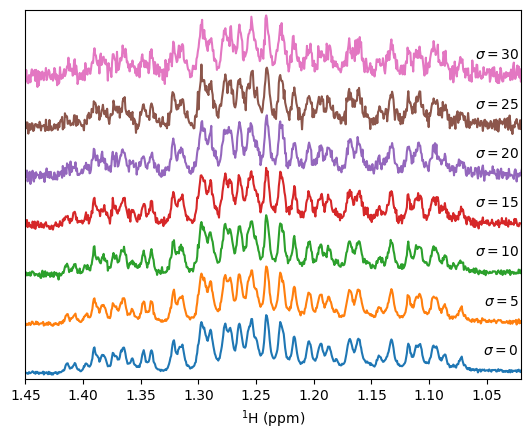

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
_, shifts = estimator_base.get_shifts(unit="ppm", meshgrid=False, pts=(1, zf_pts))
ax.set_xlim(1.45, 1.02)
ax.set_ylim(-5e3, 2.05e5)
ax.set_yticks([])
ax.set_xlabel("$^{1}$H (ppm)")

text_x = 1.022
text_yshift = 9.0e3

spectrum_yshift = 2.8e4
for i, (stdev, estimator) in enumerate(estimators.items()):
    fid = deepcopy(estimator._data[0])
    spectrum = process_1d(fid) + (i * spectrum_yshift)
    ax.plot(shifts, spectrum)
    ax.text(1.022, text_yshift + i * spectrum_yshift, "$\\sigma = {}$".format(stdev), ha="right")

## Estimating the Datasets

In [26]:
estimation_kwargs = dict(
    region=(1.45, 1.02),
    noise_region=(8.1, 7.9),
    region_unit="ppm",
    initial_guess=90,
    max_iterations=100,
    check_neg_amps_every=50,
)

In [27]:
np.random.seed(0)

rerun = True 
for stdev, estimator in estimators.items():
    try:
        if rerun:
            estimator._results = []
        estimator.get_results()
    except ValueError:
        print(ne._misc.boxed_text("ESTIMATING σ={} DATASET".format(stdev)))
        estimator.estimate(**estimation_kwargs)
        path = get_estimator_path(stdev)
        estimator.to_pickle(path, force_overwrite=True)

┌──────────────────────┐
│ESTIMATING σ=0 DATASET│
└──────────────────────┘
┌───────────────────────────────────────┐
│ESTIMATING REGION: 1.45 - 1.02 ppm (F2)│
└───────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators has been pre-defined
	Number of oscillators: 90
--> Pencil parameters: 64, 128
--> Enhanced Block Hankel matrix constructed:
	Size: 8192 x 8385
	Memory: 1.0236GiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	factors detected. These have been deleted.
	Corrected number of oscillations: 89
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 25 secs, 717 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm 

## Plotting the Estimation Results

N.B. as discussed in the main paper, the 2DJ spectra cannot be visualised at the bottom of the figures due to their insufficient sensitivty due to the application of a sine-bell. 

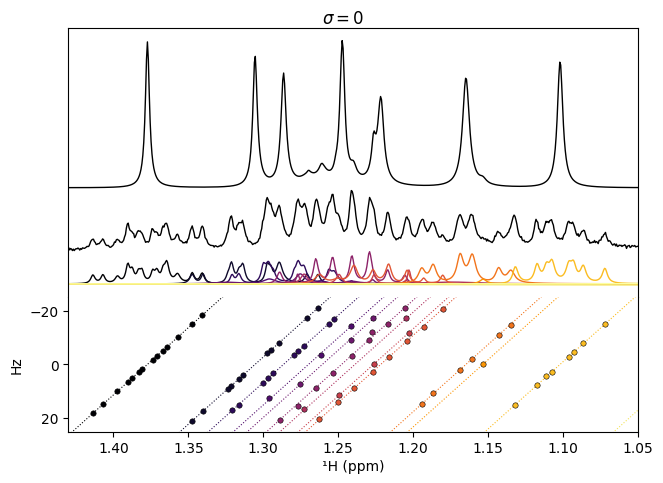

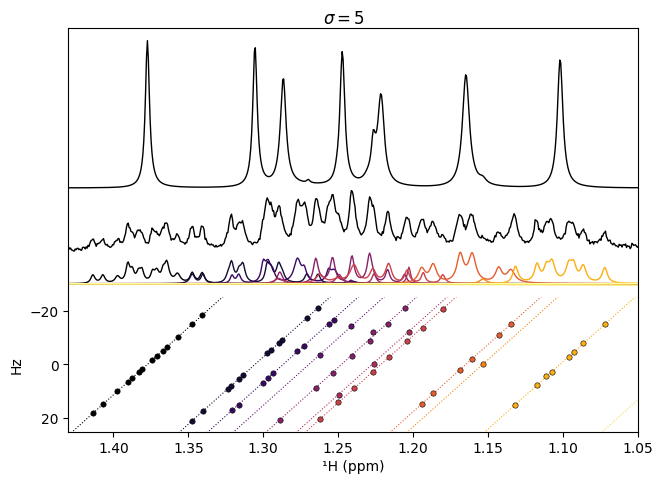

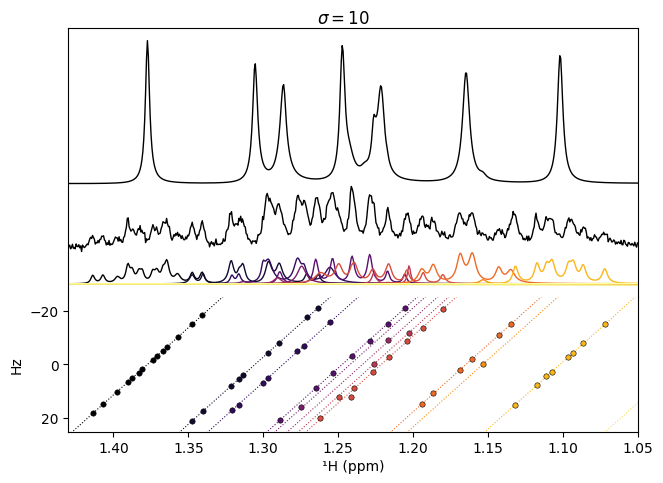

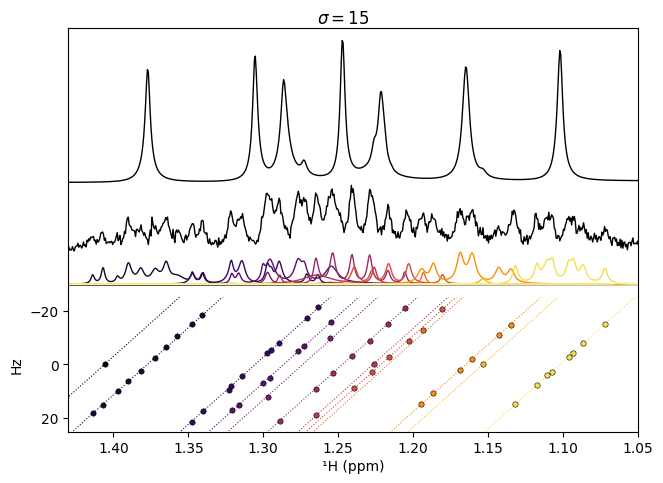

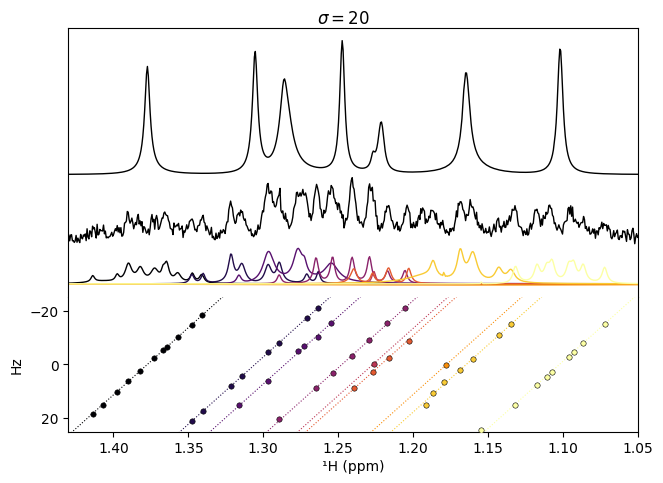

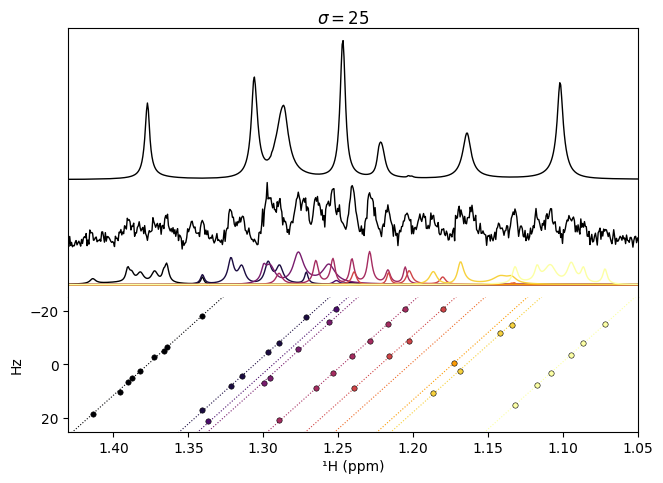

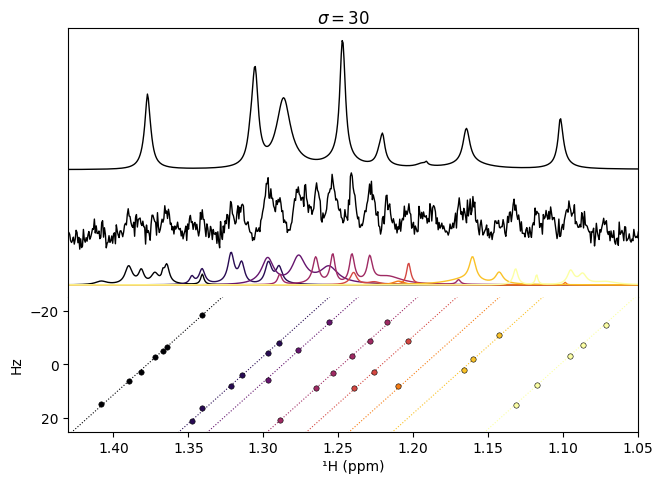

In [28]:
plot_kwargs = dict(
    contour_base=1.0e6, 
    contour_factor=2.0, 
    contour_nlevels=1, 
    marker_size=15.0,
    multiplet_show_center_freq=False,
    region_unit="ppm",
    axes_top=0.94,
    axes_bottom=0.1,
    multiplet_thold=2.0,
    multiplet_colors="inferno",
)

figs = []
for stdev, estimator in estimators.items():
    estimator.predict_multiplets(thold=plot_kwargs["multiplet_thold"], rm_spurious=True)
    fig, axs = estimator.plot_result(**plot_kwargs)
    for ax in axs[:, 0]:
        ax.set_xlim(1.43, 1.05)
    axs[1, 0].set_ylim(25, -25)
    fig.suptitle("$\\sigma = {}$".format(stdev))
    figs.append(fig)

## Constructing Noisy PSYCHE Signals

In [29]:
def process_psyche(ser: np.ndarray, sw1: float, sw2: float) -> np.ndarray:
    drop_pts = 4
    chunk_pts = int(sw2 // sw1)
    fid = ser[:, drop_pts : drop_pts + chunk_pts].flatten()
    return fid

In [30]:
from bruker_utils import BrukerDataset

psyche_dir = root / "data" / "estradiol" / "2"
psyche_estimator_dir = output_dir / "psyche_estimators"
psyche_estimator_dir.mkdir(parents=True, exist_ok=True)

psyche_estimator_path_tmpl = str(psyche_estimator_dir / "estimator_{}.pkl")

def get_psyche_estimator_path(stdev):
    if stdev == 0:
        return Path(psyche_estimator_path_tmpl.format("base"))
    return Path(psyche_estimator_path_tmpl.format(stdev))
    
all_psyche_paths = [get_psyche_estimator_path(stdev) for stdev in stdevs]

if all([path.is_file() for path in all_psyche_paths]):
    psyche_estimators = {}
    for stdev , path in zip(stdevs, all_psyche_paths):
        estimator = ne.Estimator1D.from_pickle(path)
        psyche_estimators[stdev] = estimator
else:
    psyche_ds = BrukerDataset(psyche_dir)
    ser = psyche_ds.data
    params = psyche_ds.get_parameters()
    sw1 = float(params["acqu2s"]["SW_h"])
    sw2 = float(params["acqus"]["SW_h"])
    offset = float(params["acqus"]["O1"])
    sfo = float(params["acqus"]["SFO1"])
    grpdly = params["acqus"]["GRPDLY"]

    ser = ne.sig.convdta(ser, grpdly)

    psyche_fid_base = process_psyche(deepcopy(ser), sw1, sw2)
    expinfo_psyche = ne.ExpInfo(
        dim=1,
        sw=[sw2],
        offset=offset,
        sfo=sfo,
        nuclei=["1H"],
        default_pts=psyche_fid_base.shape,
    )
    psyche_estimator_base = ne.Estimator1D(psyche_fid_base, deepcopy(expinfo_psyche))
    
    psyche_estimators = {}
    for stdev in stdevs:
        ser_noisy = deepcopy(ser)
        add_noise(ser_noisy, stdev)
        psyche_fid = process_psyche(ser_noisy, sw1, sw2)
        path = get_psyche_estimator_path(stdev)
        psyche_estimator = ne.Estimator1D(psyche_fid, deepcopy(expinfo_psyche))
        psyche_estimator.to_pickle(path)
        psyche_estimators[stdev] = psyche_estimator

Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_base.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_5.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_10.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_15.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_20.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_25.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_30.pkl.


## Comparing CUPID with PSYCHE

A series of plots are generated below, which compare the pure shift spectra produced using CUPID and PSYCHE with different added noise variances (rows) and different levels of exponential apodisation (columns). Each PSYCHE spectrum is scaled such that its has the same maximum value as the corresponding CUPID spectrum (the magnitude of the scalingis provided in the top right of each panel). All the plots have the same y-axis scale.

Moving from the original ($\sigma = 0$) to the dataset with the least noise corruption ($\sigma = 10$), the CUPID result is largely unchanged. If anything, the latter result yeilds a more desirable pure shift spectrum, since fewer features are present with derive from fitting strong coupling artifacts. It could be argued that with sufficient line-broadening, the original PSYCHE spectrum produces the expected 7 peaks. However, by the $\sigma = 10$ dataset, the spectrum is starting to resemble noise and has become unusable.

From the $\sigma=20$ dataset onwards, CUPID produces generates parameter estimates with progressively fewer component signals, leading to broader peaks with greater discrepancies in intensities. This is most clearly evidenced by the third least shielded peak at ~1.29 ppm.

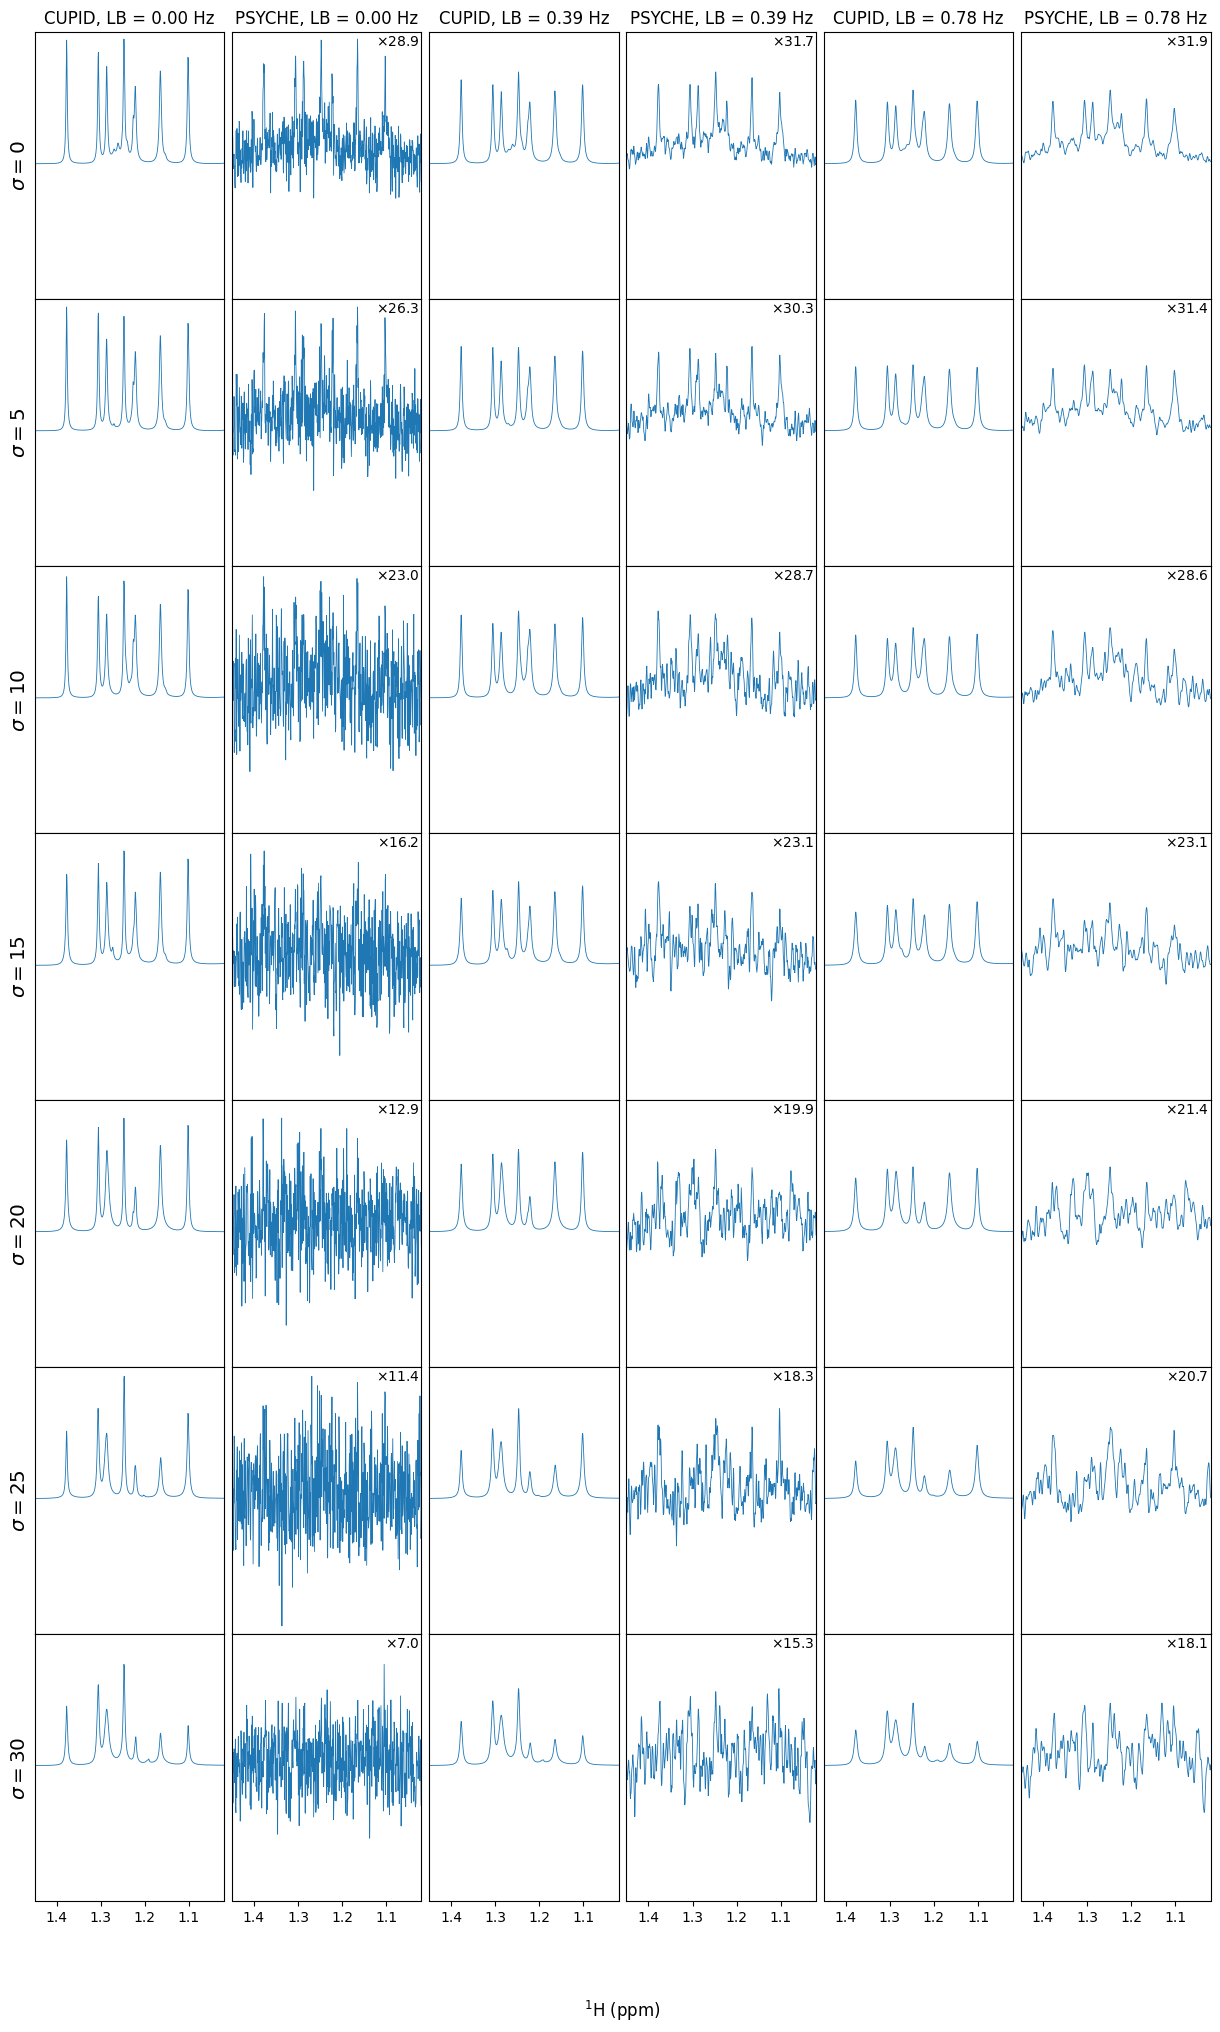

In [31]:
lbs = [0.0, 4.0, 8.0]
n_lbs = len(lbs)
n_stdevs = len(stdevs)

fig, axs = plt.subplots(
    nrows=n_stdevs,
    ncols=2 * n_lbs,
    figsize=(4.0 * n_lbs, 3.0 * n_stdevs),
    gridspec_kw=dict(
        left=0.01,
        right=0.99,
        top=0.95,
        bottom=0.06,
        wspace=0.04,
        hspace=0.0,
    )
)
plt.rcParams["lines.linewidth"] = 0.6

left, right = estimation_kwargs["region"]
xticks = [1.4, 1.3, 1.2, 1.1]
ylim = (-1.0e4, 1.0e5)
psyche_phase = (1.428, -5.942)
for ax_row in axs:
    for ax in ax_row:
        ax.set_xlim(left, right)
        ax.set_xticks(xticks)
        ax.set_ylim(ylim)

        
left_idx = np.searchsorted(-shifts, -left, side='right')
right_idx = np.searchsorted(-shifts, -right, side='left')
shifts_slice = shifts[left_idx : right_idx + 1]
ymin, ymax = 0.0, 0.0
for ax_row, stdev in enumerate(stdevs):
    cupid_estimator = estimators[stdev]
    cupid_fid = cupid_estimator.cupid_signal()
    psyche_estimator = psyche_estimators[stdev]
    psyche_fid = deepcopy(psyche_estimator._data)
    for i, lb in enumerate(lbs):
        cupid_spectrum = process_1d(deepcopy(cupid_fid), lb=lb)[left_idx : right_idx + 1]
        psyche_spectrum = process_1d(deepcopy(psyche_fid), lb=lb, p0_p1=psyche_phase)[left_idx : right_idx + 1]
        cupid_max, cupid_min = np.max(cupid_spectrum), np.min(cupid_spectrum)
        psyche_max, psyche_min = np.max(psyche_spectrum), np.min(psyche_spectrum)
        scale = cupid_max / psyche_max
        psyche_spectrum *= scale
        if (mx := max(cupid_max, scale * psyche_max)) > ymax:
            ymax = mx
        if (mn := min(cupid_min, scale * psyche_min)) < ymin:
            ymin = mn
        cupid_ax = axs[ax_row, 2 * i]
        psyche_ax = axs[ax_row, 2 * i + 1]
        cupid_ax.plot(shifts_slice, cupid_spectrum)
        psyche_ax.plot(shifts_slice, psyche_spectrum)
        psyche_ax.text(0.99, 0.99, "$\\times {:.1f}$".format(scale), ha="right", va="top", transform=psyche_ax.transAxes)
        if ax_row == 0:
            lb_hz = (lb * cupid_estimator.sw()[1]) / (np.pi * (zf_pts - 1))
            cupid_ax.set_title("CUPID, LB = {:.2f} Hz".format(lb_hz))
            psyche_ax.set_title("PSYCHE, LB = {:.2f} Hz".format(lb_hz))
        if i == 0:
            cupid_ax.set_ylabel("$\\sigma = {}$".format(stdev), fontsize="x-large")
        
ypad = 0.03 * (ymax - ymin)
for ax in axs.flatten():
    ax.set_ylim(ymin - ypad, ymax + ypad)
    ax.set_yticks([])

fig.text(0.5, 0.005, "$^{1}$H (ppm)", ha="center", fontsize="large");